RMSE: 6.20
R² Score: -0.26


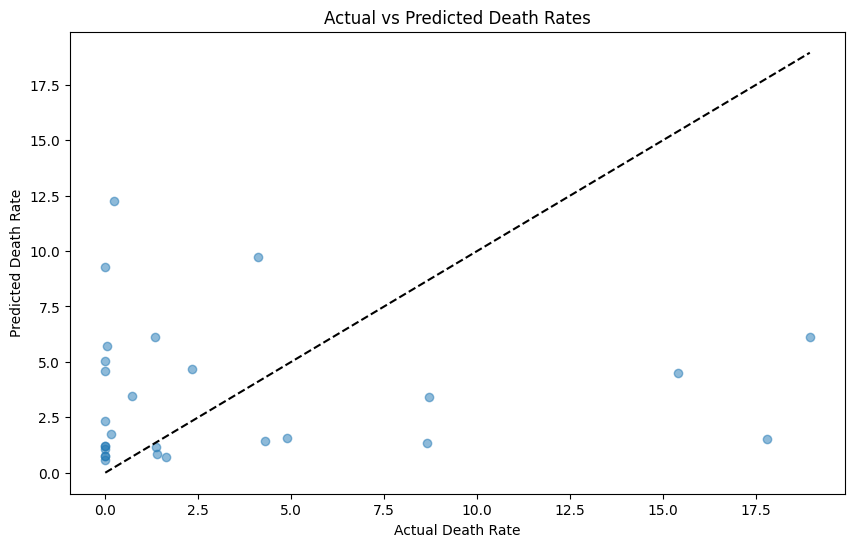

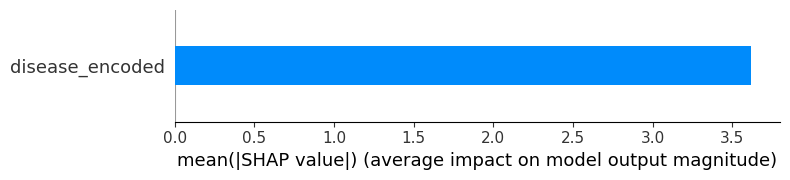

In [3]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import streamlit as st

# 3.1 Data Preparation
def load_and_preprocess_data():
    """Load and preprocess the WHO dataset"""
    df = pd.read_csv(r"C:\Users\Administrator\Downloads\rep_ctis3\GHE_FULL_DD.csv")
    
    # Filter for Rwanda males 2021
    rwanda_df = df[(df['DIM_COUNTRY_CODE'] == 'RWA') & 
                   (df['DIM_SEX_CODE'] == 'MLE') & 
                   (df['DIM_YEAR_CODE'] == 2021)]
    
    # Feature engineering
    rwanda_df = rwanda_df[['DIM_GHECAUSE_TITLE', 'VAL_DTHS_RATE100K_NUMERIC']]
    rwanda_df.columns = ['disease', 'death_rate']
    
    # Encode categorical features
    le = LabelEncoder()
    rwanda_df['disease_encoded'] = le.fit_transform(rwanda_df['disease'])
    
    return rwanda_df, le

# 3.2 Model Training
def train_ensemble_model(X, y):
    """Train ensemble of RandomForest and XGBoost"""
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Initialize models
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    xgb = GradientBoostingRegressor(n_estimators=100, random_state=42)
    
    # Train models
    rf.fit(X_train, y_train)
    xgb.fit(X_train, y_train)
    
    # Ensemble predictions
    rf_pred = rf.predict(X_test)
    xgb_pred = xgb.predict(X_test)
    ensemble_pred = (rf_pred + xgb_pred) / 2
    
    return rf, xgb, X_test, y_test, ensemble_pred

# 4. Model Evaluation
def evaluate_model(y_true, y_pred):
    """Evaluate model performance"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    print(f"RMSE: {rmse:.2f}")
    print(f"R² Score: {r2:.2f}")
    
    # Visualization
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--')
    plt.xlabel('Actual Death Rate')
    plt.ylabel('Predicted Death Rate')
    plt.title('Actual vs Predicted Death Rates')
    plt.show()
    
    return rmse, r2

# 5. Structured Main Function
def main():
    """Main execution function"""
    # Load and preprocess data
    data, label_encoder = load_and_preprocess_data()
    
    # Prepare features and target
    X = data[['disease_encoded']]
    y = data['death_rate']
    
    # Train model
    rf, xgb, X_test, y_test, ensemble_pred = train_ensemble_model(X, y)
    
    # Evaluate
    rmse, r2 = evaluate_model(y_test, ensemble_pred)
    
    # Feature importance
    explainer = shap.TreeExplainer(rf)
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values, X_test, plot_type="bar")
    
    return rf, xgb, label_encoder

if __name__ == "__main__":
    rf_model, xgb_model, encoder = main()

# 6. Innovation Components

# 6.1 Interactive Streamlit App
def run_streamlit_app(model, encoder):
    """Create interactive prediction interface"""
    st.title('Rwanda Male Mortality Predictor')
    
    # User inputs
    disease = st.selectbox('Select Disease', encoder.classes_)
    
    if st.button('Predict'):
        # Encode input
        disease_encoded = encoder.transform([disease])[0]
        
        # Predict with both models
        rf_pred = rf_model.predict([[disease_encoded]])[0]
        xgb_pred = xgb_model.predict([[disease_encoded]])[0]
        avg_pred = (rf_pred + xgb_pred) / 2
        
        # Display results
        st.subheader('Prediction Results')
        col1, col2, col3 = st.columns(3)
        col1.metric("RandomForest", f"{rf_pred:.1f}")
        col2.metric("XGBoost", f"{xgb_pred:.1f}")
        col3.metric("Ensemble Avg", f"{avg_pred:.1f}", delta_color="off")
        
        # Visual explanation
        st.subheader('Feature Importance')
        explainer = shap.TreeExplainer(rf_model)
        shap_value = explainer.shap_values([[disease_encoded]])[0]
        fig, ax = plt.subplots()
        shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_value[0], 
                                              feature_names=['Disease Encoded'], show=False)
        st.pyplot(fig)

# Uncomment to run the Streamlit app
# run_streamlit_app(rf_model, encoder)

# 6.2 PDF Report Generation
def generate_pdf_report():
    """Generate PDF report of analysis"""
    from fpdf import FPDF
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font("Arial", size=12)
    
    # Add content
    pdf.cell(200, 10, txt="Rwanda Male Mortality Analysis Report", ln=1, align='C')
    pdf.cell(200, 10, txt=f"Model RMSE: {rmse:.2f}", ln=1)
    pdf.cell(200, 10, txt=f"Model R²: {r2:.2f}", ln=1)
    
    # Save plots to images
    plt.savefig('temp_plot.png')
    pdf.image('temp_plot.png', x=10, y=50, w=180)
    
    pdf.output("mortality_report.pdf")

2025-07-30 17:56:24.504 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-30 17:56:24.530 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-07-30 17:56:24.581 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-30 17:56:28.204 
  command:

    streamlit run C:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-07-30 17:56:28.206 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-30 17:56:28.213 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-30 17:56:28.216 Thread 'MainThread': missing ScriptRunContext! T

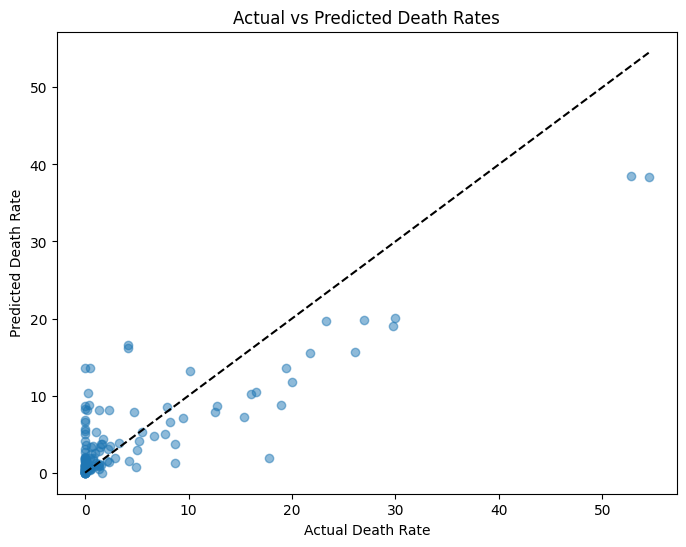

In [4]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import streamlit as st
from io import StringIO

# Set page config for Streamlit
st.set_page_config(page_title="Rwanda Mortality Predictor", layout="wide")

# 1. Data Preparation Functions
@st.cache_data
def load_and_preprocess_data():
    """Load and preprocess the WHO dataset"""
    try:
        # Try to load from uploaded file first
        if 'uploaded_file' in st.session_state:
            df = pd.read_csv(st.session_state.uploaded_file)
        else:
            # Fallback to default dataset
            df = pd.read_csv(r"C:\Users\Administrator\Downloads\rep_ctis3\GHE_FULL_DD.csv")
        
        # Filter for Rwanda males 2021 (or use user-specified filters)
        country = st.session_state.get('country_filter', 'RWA')
        sex = st.session_state.get('sex_filter', 'MLE')
        year = st.session_state.get('year_filter', 2021)
        
        filtered_df = df[(df['DIM_COUNTRY_CODE'] == country) & 
                       (df['DIM_SEX_CODE'] == sex) & 
                       (df['DIM_YEAR_CODE'] == year)]
        
        # Feature engineering
        filtered_df = filtered_df[['DIM_GHECAUSE_TITLE', 'VAL_DTHS_RATE100K_NUMERIC']]
        filtered_df.columns = ['disease', 'death_rate']
        
        # Encode categorical features
        le = LabelEncoder()
        filtered_df['disease_encoded'] = le.fit_transform(filtered_df['disease'])
        
        return filtered_df, le
    
    except Exception as e:
        st.error(f"Error loading data: {str(e)}")
        return None, None

# 2. Model Training Functions
@st.cache_resource
def train_models(X, y):
    """Train ensemble of RandomForest and XGBoost"""
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Initialize models
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    xgb = GradientBoostingRegressor(n_estimators=100, random_state=42)
    
    # Train models
    rf.fit(X_train, y_train)
    xgb.fit(X_train, y_train)
    
    # Evaluate models
    rf_pred = rf.predict(X_test)
    xgb_pred = xgb.predict(X_test)
    ensemble_pred = (rf_pred + xgb_pred) / 2
    
    rmse = np.sqrt(mean_squared_error(y_test, ensemble_pred))
    r2 = r2_score(y_test, ensemble_pred)
    
    return rf, xgb, rmse, r2

# 3. Prediction Functions
def make_prediction(model, encoder, disease_input):
    """Make prediction for a given disease"""
    try:
        if disease_input not in encoder.classes_:
            st.warning(f"Disease '{disease_input}' not in trained data. Using closest match.")
            # Find closest match
            matches = [d for d in encoder.classes_ if disease_input.lower() in d.lower()]
            if matches:
                disease_input = matches[0]
                st.info(f"Using '{disease_input}' for prediction")
            else:
                return None, None, None
        
        disease_encoded = encoder.transform([disease_input])[0]
        rf_pred = rf_model.predict([[disease_encoded]])[0]
        xgb_pred = xgb_model.predict([[disease_encoded]])[0]
        avg_pred = (rf_pred + xgb_pred) / 2
        
        return rf_pred, xgb_pred, avg_pred
    
    except Exception as e:
        st.error(f"Prediction error: {str(e)}")
        return None, None, None

# 4. Visualization Functions
def plot_predictions(y_true, y_pred):
    """Plot actual vs predicted values"""
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(y_true, y_pred, alpha=0.5)
    ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--')
    ax.set_xlabel('Actual Death Rate')
    ax.set_ylabel('Predicted Death Rate')
    ax.set_title('Actual vs Predicted Death Rates')
    st.pyplot(fig)

def plot_shap_explanation(model, encoder, disease_input):
    """Generate SHAP explanation for a prediction"""
    try:
        disease_encoded = encoder.transform([disease_input])[0]
        explainer = shap.TreeExplainer(model)
        shap_value = explainer.shap_values([[disease_encoded]])
        
        fig, ax = plt.subplots()
        shap.plots._waterfall.waterfall_legacy(explainer.expected_value, 
                                             shap_value[0][0], 
                                             feature_names=['Disease Encoded'], 
                                             show=False)
        st.pyplot(fig)
    except Exception as e:
        st.error(f"Could not generate explanation: {str(e)}")

# 5. Main Streamlit App
def main():
    """Main Streamlit application"""
    st.title("🇷🇼 Rwanda Male Mortality Predictor")
    st.markdown("""
    This interactive tool predicts mortality rates for different diseases among Rwandan males 
    based on WHO data. Upload your own data or use the default dataset.
    """)
    
    # Initialize session state
    if 'models_trained' not in st.session_state:
        st.session_state.models_trained = False
    
    # Sidebar for data upload and filters
    with st.sidebar:
        st.header("Data Configuration")
        
        # File uploader
        uploaded_file = st.file_uploader("Upload your own dataset (CSV)", type=['csv'])
        if uploaded_file is not None:
            st.session_state.uploaded_file = uploaded_file
            st.success("File uploaded successfully!")
            st.session_state.models_trained = False  # Reset models if new data uploaded
        
        # Filters
        st.subheader("Data Filters")
        country_filter = st.text_input("Country Code (e.g., RWA)", "RWA")
        sex_filter = st.selectbox("Sex", ["MLE", "FMLE"], index=0)
        year_filter = st.number_input("Year", min_value=2000, max_value=2023, value=2021)
        
        if st.button("Apply Filters"):
            st.session_state.country_filter = country_filter
            st.session_state.sex_filter = sex_filter
            st.session_state.year_filter = year_filter
            st.session_state.models_trained = False  # Reset models if filters change
    
    # Load and prepare data
    data, encoder = load_and_preprocess_data()
    
    if data is not None:
        # Show data preview
        st.subheader("Data Preview")
        st.dataframe(data.head())
        
        # Train models (only if not already trained or if data changed)
        if not st.session_state.models_trained or 'rf_model' not in st.session_state:
            with st.spinner("Training models..."):
                X = data[['disease_encoded']]
                y = data['death_rate']
                
                st.session_state.rf_model, st.session_state.xgb_model, \
                st.session_state.rmse, st.session_state.r2 = train_models(X, y)
                
                st.session_state.models_trained = True
                st.success("Models trained successfully!")
        
        # Display model performance
        st.subheader("Model Performance")
        col1, col2 = st.columns(2)
        col1.metric("RMSE", f"{st.session_state.rmse:.2f}")
        col2.metric("R² Score", f"{st.session_state.r2:.2f}")
        
        # Prediction section
        st.subheader("Make Predictions")
        
        # Option 1: Select from existing diseases
        selected_disease = st.selectbox("Select a disease from the dataset", 
                                      options=encoder.classes_)
        
        # Option 2: Free-form input
        custom_disease = st.text_input("Or enter a custom disease name")
        
        disease_input = custom_disease if custom_disease else selected_disease
        
        if st.button("Predict Mortality Rate"):
            if disease_input:
                with st.spinner("Making prediction..."):
                    rf_pred, xgb_pred, avg_pred = make_prediction(
                        st.session_state.rf_model, 
                        encoder, 
                        disease_input
                    )
                    
                    if rf_pred is not None:
                        st.success("Prediction complete!")
                        
                        # Display results
                        st.subheader("Prediction Results")
                        cols = st.columns(3)
                        cols[0].metric("RandomForest", f"{rf_pred:.1f}", "deaths per 100k")
                        cols[1].metric("XGBoost", f"{xgb_pred:.1f}", "deaths per 100k")
                        cols[2].metric("Ensemble Average", f"{avg_pred:.1f}", "deaths per 100k")
                        
                        # Show explanation
                        st.subheader("Model Explanation")
                        plot_shap_explanation(st.session_state.rf_model, encoder, disease_input)
                    else:
                        st.error("Could not make prediction for this disease")
            else:
                st.warning("Please select or enter a disease name")
        
        # Data visualization section
        st.subheader("Data Visualization")
        plot_predictions(y, st.session_state.rf_model.predict(X))
        
        # Download section
        st.subheader("Download Results")
        if st.button("Generate PDF Report"):
            with st.spinner("Generating report..."):
                generate_pdf_report()
                st.success("Report generated!")
                with open("mortality_report.pdf", "rb") as file:
                    st.download_button(
                        label="Download PDF Report",
                        data=file,
                        file_name="mortality_report.pdf",
                        mime="application/pdf"
                    )

# PDF Report Generation
def generate_pdf_report():
    """Generate PDF report of analysis"""
    from fpdf import FPDF
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font("Arial", size=12)
    
    # Add content
    pdf.cell(200, 10, txt="Rwanda Male Mortality Analysis Report", ln=1, align='C')
    pdf.cell(200, 10, txt=f"Model RMSE: {st.session_state.rmse:.2f}", ln=1)
    pdf.cell(200, 10, txt=f"Model R²: {st.session_state.r2:.2f}", ln=1)
    
    # Save plots to images
    plt.savefig('temp_plot.png')
    pdf.image('temp_plot.png', x=10, y=50, w=180)
    
    pdf.output("mortality_report.pdf")

if __name__ == "__main__":
    main()